Agora vamos começar a trabalhar no processo de classificação de faces, no sentido de dada uma face - quem ela é? Ela é o Michel, ela é o José, ela é a Maria, por exemplo.

 Só que para fazermos esse processo de classificação e de construção de um classificador, eu preciso ter exemplos de imagens, o que chamamos de conjunto de dados. No exemplo em que vamos trabalhar agora, eu peguei um conjunto de dados da Georgia Tech e nele temos 15 imagens por pessoa.

 Então para podermos trabalhar, precisamos analisar essas imagens e até mesmo verificar se o tamanho delas está adequado, se eu preciso fazer algum tipo de normalização e coisas desse tipo.

 Isso é o que chamamos de pré-processamento, então antes de treinarmos, eu preciso verificar se as imagens estão certas, preciso separar essas imagens do que eu chamo de treinamento, do que eu chamo de teste de validação, para enfim então começar a treinar.

 Então o que vamos começar a fazer agora é o que chamamos de “pré-processamento”. Em primeiro lugar, vamos organizar esses arquivos e depois normalizar pelo seu tamanho. Primeiro vamos dar uma investigada nesses arquivos que temos da Georgia Tech.

 Nesse caso aqui, acabamos pegando um conjunto de dados que o rosto já está segmentado, então eu não vou precisa usar o Haar Cascade que nós vimos anteriormente, justamente porque essas imagens já estão recortadas.

 Se pegássemos alguma imagem de um outro dataset e tem a imagem da pessoa, de corpo inteiro ou então parcial, nós precisaríamos pegar um classificador desse tipo para segmentar somente o rosto, para poder classificar, então vamos começar.

In [148]:
import cv2
import matplotlib.pyplot as plt
from os import listdir, path, makedirs
from os.path import isfile, join

import shutil
import numpy as np

from sklearn.metrics import accuracy_score

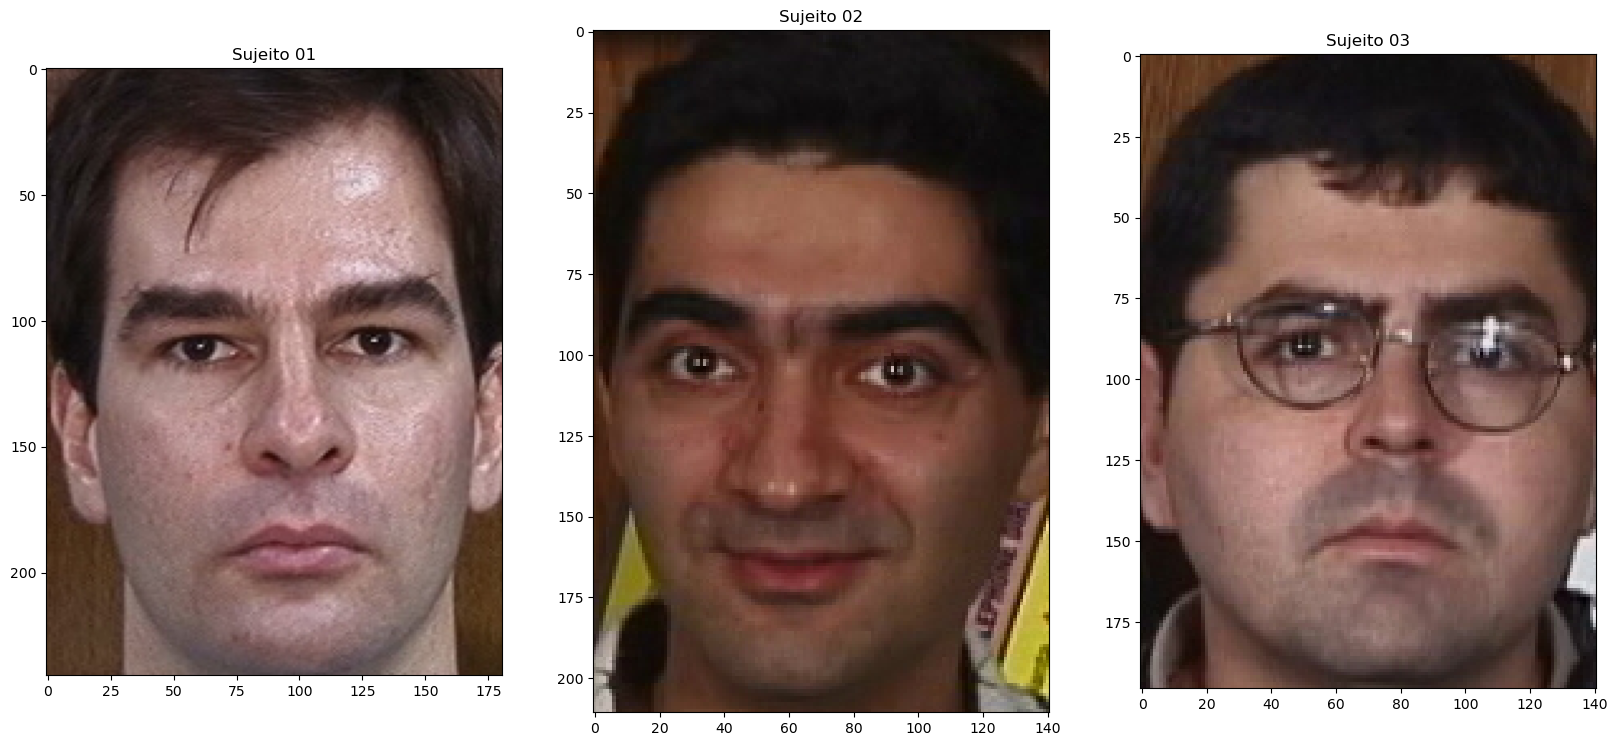

In [146]:
imagem_face_1 = cv2.imread("imagens/cropped_faces/s01_01.jpg")
imagem_face_1 = cv2.cvtColor(imagem_face_1, cv2.COLOR_BGR2RGB)

imagem_face_2 = cv2.imread("imagens/cropped_faces/s02_01.jpg")
imagem_face_2 = cv2.cvtColor(imagem_face_2, cv2.COLOR_BGR2RGB)

imagem_face_3 = cv2.imread("imagens/cropped_faces/s03_01.jpg")
imagem_face_3 = cv2.cvtColor(imagem_face_3, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title("Sujeito 01")
plt.imshow(imagem_face_1)

plt.subplot(132)
plt.title("Sujeito 02")
plt.imshow(imagem_face_2)

plt.subplot(133)
plt.title("Sujeito 03")
plt.imshow(imagem_face_3)

Percebemos que as imagens têm tamanhos variados. Podemos conferir isso verificando o shape das imagens

In [63]:
imagem_face_1.shape

(241, 181, 3)

In [64]:
imagem_face_2.shape

(211, 141, 3)

In [65]:
imagem_face_3.shape

(196, 141, 3)

Vamos precisar normalizar as imagens e também separar o universo de treino com o de teste, sendo que nesse caso temos 15 imagens de cada uma dessas pessoas. Serão 10 imagens de treino e 5 de teste. Precisamos importar as bibliotecas pra importar dessa forma

In [66]:
faces_caminho = "imagens/cropped_faces/"
lista_arq_faces = [f for f in listdir(faces_caminho) if isfile(join(faces_caminho, f))]

In [89]:
lista_arq_faces[0]

's03_07.jpg'

In [90]:
len(lista_arq_faces)

750

Temos 750 imagens na lista

In [95]:
faces_path_treino = "imagens/treino/"
faces_path_teste = "imagens/teste/"

if not path.exists(faces_path_treino):
    makedirs(faces_path_treino)

if not path.exists(faces_path_teste):
    makedirs(faces_path_teste)

for arq in lista_arq_faces:
    sujeitos = arq[1:3]
    numero = arq[4:6]

    if int(numero) <= 10:
        shutil.copyfile(faces_caminho + arq, faces_path_treino + arq)
    else:
        shutil.copyfile(faces_caminho + arq, faces_path_teste + arq)

Agora vamos trabalhar no redimensionamento e também na conversão do espaço de cor dessas imagens porque os classificadores, do jeito que vamos trabalhar, também lidam com imagens em escala de cinza, então vamos fazer já essa etapa de padronização não só do tamanho da imagem, mas também do espaço de cores.

Então vamos criar uma função que vai fazer exatamente essas duas tarefas: a tarefa de redimensionar a imagem e a tarefa de converter para o espaço de cores em escala de cinza. Vamos arbitrar uma tamanho mais ou menos de 200 por 200.

In [96]:
def padronizar_imagem(imagem_caminho):
    imagem = cv2.imread(imagem_caminho, cv2.IMREAD_GRAYSCALE)
    imagem = cv2.resize(imagem, (200,200), interpolation=cv2.INTER_LANCZOS4)
    return imagem

 Depois eu preciso colocar um comando aqui que é a “interpolarion”. O que a “interpolation” faz? Imagine que você tenha uma imagem pequena e você quer que ela se amplie.

Então se você tem uma imagem de 100x100, você quer que ela seja no tamanho 200x200, nós precisamos preencher pixels que não estavam lá. Quando você tem uma imagem grande e diminui, não tem problema, vamos tirar pixel fora.

Mas quando queremos aumentar sua imagem, eu preciso escolher o algoritmo de interpolação. Eu vou escolher um aqui, que é um dos mais avançados e que tem a menor distorção quando ele aumenta uma imagem de um tamanho menor para o tamanho maior.

Esse algoritmo de “interpolation” se chama “LANCZOS4”, então ficaria assim: “, interpolation=cv2.INTER_LANCZOS4)”. É o mais avançado, existem vários: o de mediano, de média. Esse aqui, a execução dele é um pouquinho mais lenta - para o nosso caso é imperceptível - mas em compensação, o retorno que ele dá em precisão, em não distorcer a imagem é muito grande.



In [97]:
lista_faces_treino = [f for f in listdir(faces_path_treino) if isfile(join(faces_path_treino, f))]
lista_faces_teste = [f for f in listdir(faces_path_teste) if isfile(join(faces_path_teste, f))]

In [98]:
list_faces_treino[0]

's03_07.jpg'

In [99]:
list_faces_teste[0]

's45_12.jpg'

In [100]:
dados_treinamento, sujeitos_treinamento = [], []

for i, arq in enumerate(lista_faces_treino):
    imagem_path = faces_path_treino + arq
    imagem = padronizar_imagem(imagem_path)
    dados_treinamento.append(imagem)
    sujeito = arq[1:3]
    sujeitos_treinamento.append(int(sujeito))

In [101]:
len(dados_treinamento)

500

In [104]:
len(sujeitos_treinamento)

500

In [105]:
dados_teste, sujeitos_teste = [], []

for i, arq in enumerate(lista_faces_teste):
    imagem_path = faces_path_teste + arq
    imagem = padronizar_imagem(imagem_path)
    dados_teste.append(imagem)
    sujeito = arq[1:3]
    sujeitos_teste.append(int(sujeito))

In [106]:
len(dados_teste)

250

In [107]:
len(sujeitos_teste)

250

Text(0.5, 1.0, '3')

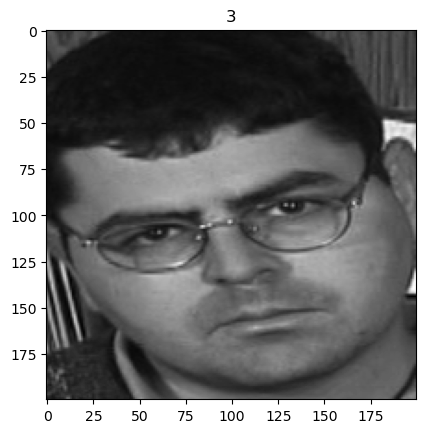

In [108]:
plt.imshow(dados_treinamento[0], cmap="gray")
plt.title(sujeitos_treinamento[0])

Text(0.5, 1.0, '45')

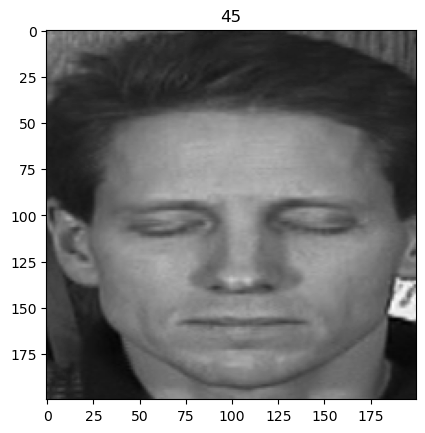

In [109]:
plt.imshow(dados_teste[0], cmap="gray")
plt.title(sujeitos_teste[0])

Algoritmos de Classificação


Classificador Eingenfaces
Vamos agora começar a trabalhar com os algoritmos de classificação de faces, começando com o Eigenfaces. Antes de começarmos a trabalhar com o Eigenfaces, eu só preciso converter a lista de sujeitos, ou labels, para o formato de array de 32bits.

Então nós precisamos fazer essa conversão, vamos usar o NumPy para isso. Primeiro vamos aqui em cima verificar se o NumPy está sendo importado. Vamos dar o comando “import numpy as np” - que é a palavra abreviada para chamarmos ele.

In [110]:
sujeitos_treinamento = np.asarray(sujeitos_treinamento, dtype=np.int32)
sujeitos_teste = np.asarray(sujeitos_teste, dtype=np.int32)

In [111]:
modelo_eingenfaces = cv2.face.EigenFaceRecognizer_create()

In [115]:
modelo_eignenfaces.train(dados_treinamento, sujeitos_treinamento)

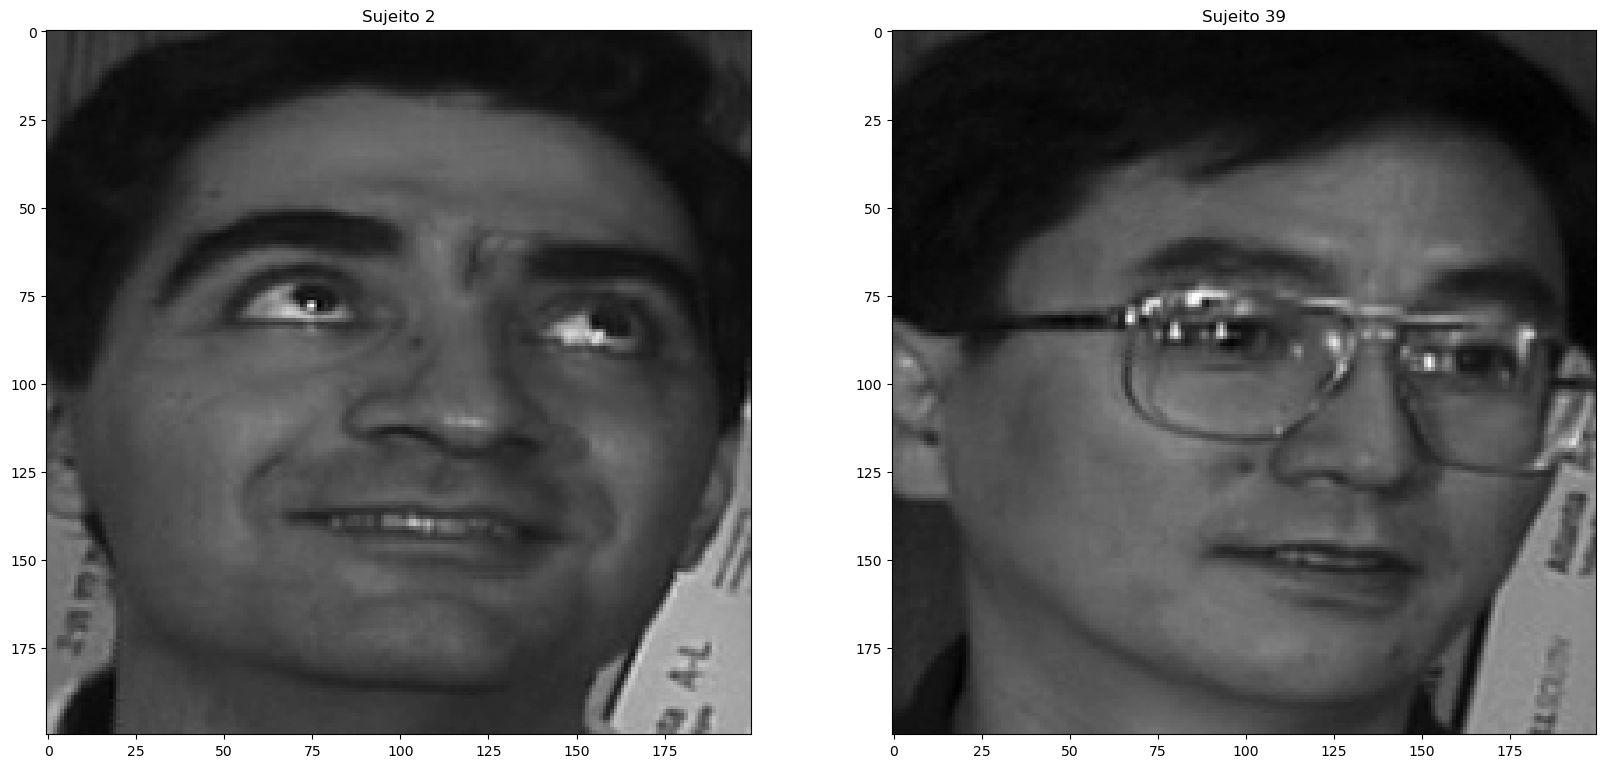

In [124]:
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.title("Sujeito " + str(sujeitos_teste[100]))
plt.imshow(dados_teste[100], cmap="gray")

plt.subplot(122)
plt.title("Sujeito " + str(sujeitos_teste[150]))
plt.imshow(dados_teste[150], cmap="gray")

plt.show()

In [125]:
predicao = modelo_eignenfaces.predict(dados_teste[100])
print(predicao)

(2, 4620.627663604537)


In [126]:
predicao = modelo_eignenfaces.predict(dados_teste[150])
print(predicao)

(39, 4620.405253442982)


Agora eu quero mostrar para vocês como isso funciona por detrás dos panos, ou seja, “embaixo do capô”, como o Eigenfaces consegue identificar as características que foram capazes de fazer essa inferência bem sucedida.

Primeiro que o Eigenfaces usa o “PCA”, que é o “Principal Component Analysis”, que é uma forma de você reduzir dimensionalidade de determinadas características que você tem à sua disposição.

E o Eigenfaces faz o quê? Ele maximiza a variância de intra classe. Qual é o “trade off” disso? O que acontece quando ele faz isso? Imagine que você tem aqui o plano de faces, então eu posso ter onde eu tenho a “face A”.

Eu determino a “Face Média”, que é o ponto de origem de onde eu vou partir para eu determinar características associadas à essa face, então pense o seguinte: imagine que essa pessoa aqui, de “Face Normal”, faz parte de um dos sujeitos do meu treinamento.

Eu tiro a “Face Média” nesse sujeito e à medida que eu tenho os componentes principais - ou seja, quais as características mais importantes que fazem essa face ser ela mesma? Então eu posso decompor esses componentes de tal forma que dentro do Eigenfaces, dentro desse plano de faces, eu consigo estabelecer características.

Então, por exemplo, o Componente Principal 1 pode ser associado a componente de barba. O Componente Principal 2 pode ser se associado ao componente de você não ter cabelo, então eu consigo estabelecer essas diferenças de faces dentro do meu plano. Qual é o problema que eu posso ter em relação a isso?

Por exemplo: pessoas que têm basicamente as mesmas condições - barbas ou ausência de cabelos, elas podem estar muito próximos - isso pode prejudicar um pouco a capacidade de identificação nesse tipo de classificador.

Então a forma de identificarmos uma face de teste - por exemplo, igual eu estou colocando aqui - é você determinar qual é a distância de similaridade nesse plano, então se for muito próxima, vamos ter valores próximos a 0, ou seja, se for idêntico, ele é 0. Se for muito distante, é o infinito.

 Então você pode até ter uma face de teste que corresponde à uma determinada classe mas se essa distância estiver muito grande, significa que de fato confiável essa medida não pode ser, então temos que ficar de olho nisso.

E o Eigenfaces também tem uma característica que pode te prejudicar: se você tem etapa de classificação onde as imagens podem sofrer diferenças de luminosidade, isso pode interferir negativamente no classificador.

Classificador FIsher Face

O algoritmo FisherFaces é um pouco diferente dos demais. O FisherFaces foi feito de uma forma que consegue maximizar não os componentes e informações dentro da própria classe, mas sim de extra classe, ou seja, ele quer maximizar diferentes classes para que fique fácil o classificador entender se é a pessoa A, B ou C.

Então dessa forma, ele consegue ser um pouco mais robusto do que algoritmos como o Eigenfaces, por exemplo. Vamos treinar as nossas imagens agora por esse outro tipo de classificador, que seria o FisherFaces.


In [128]:
modelo_fisherfaces = cv2.face.FisherFaceRecognizer_create()

modelo_fisherfaces.train(dados_treinamento, sujeitos_treinamento)

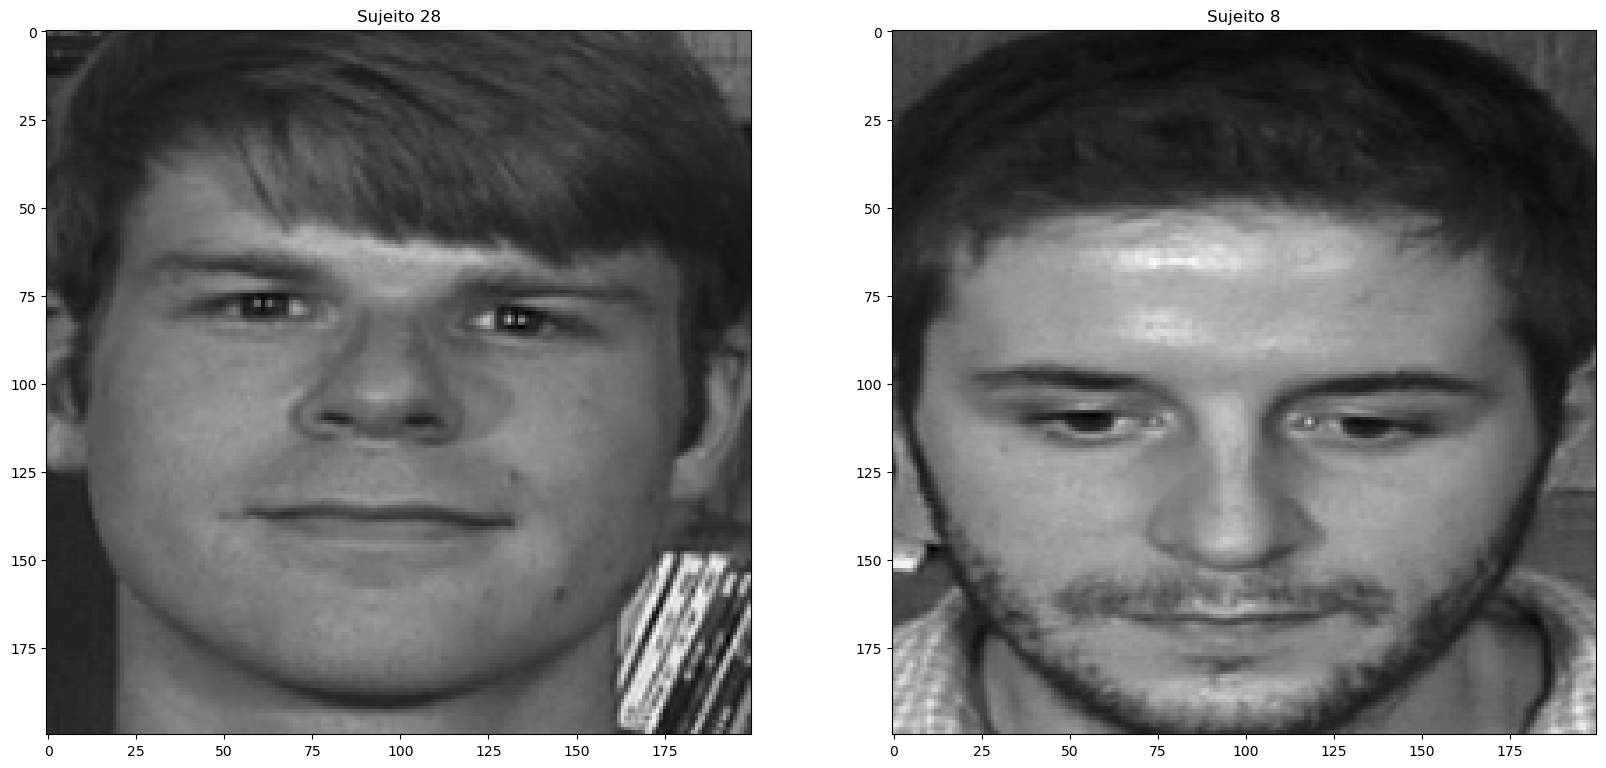

In [133]:
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.title("Sujeito " + str(sujeitos_teste[67]))
plt.imshow(dados_teste[67], cmap="gray")

plt.subplot(122)
plt.title("Sujeito " + str(sujeitos_teste[77]))
plt.imshow(dados_teste[77], cmap="gray")

plt.show()

In [141]:
predicao = modelo_fisherfaces.predict(dados_teste[67])
print(predicao)

(28, 1185.3268950423644)


In [142]:
predicao = modelo_fisherfaces.predict(dados_teste[77])
print(predicao)

(32, 1093.4393733082704)


Então o FisherFaces é um pouquinho diferente do que o Eigenfaces. Vamos dar uma olhada em como ele funciona em relação - até mesmo comparando com o Eigenfaces. O FisherFaces, diferentemente do Eigenfaces, usa o “LDA”. O “LDA” é bem parecido com o “PCA”, só que o “LDA”, o objetivo dele é fazer o quê?

Maximizar a variância entre classes, então ele é muito bom para separar pessoas de classes diferentes - para separar o Michel de uma outra pessoa, do João e da Maria - ele lida muito bem com isso.

Ainda que tenhamos algum semelhança, vamos estar mais separados se comparássemos com o Eigenfaces, então o formato é o mesmo: vamos trabalhar um plano de faces.

Só que a diferença em relação ao Eigenfaces é que a combinação linear das características dos sujeitos que vamos treinar é que vai determinar aqui, no plano de faces, qual é a distância entre a face de inferência com a face que foi treinada, então ele é bom. Inclusice o FisherFaces, para você criar modelos para determinar expressões faciais.

Então você pode ter diferentes expressões faciais em diferentes classes, ainda que seja da mesma pessoa, para você treinar emoções ou coisas desse tipo, e o Eigenfaces lida um pouco melhor com aquelas questões de distorções de iluminação, ele ainda sofre um pouco com isso mas ele já é um pouco melhor do que o Eigenfaces.

Essa característica de já separar e maximizar as classes é algo positivo que torna esse algoritmo - dependendo das condições, ou seja, se você tiver imagens mais padronizadas ou se você for comparar imagens padronizadas. Eu digo assim, imagens onde a pessoa está de frente de uma câmera, não tem muito ruído, então não está muito inclinado - ele tende a ser um pouco melhor do que o Eigenfaces.


Algoritmo LBPH

O algoritmo “LBPH” é considerado um dos mais robustos quando comparamos com o Eigenfaces e até com o FisherFaces. Ele é robusto porque durante a construção dele, tem umas operações de filtro que atenuam bastante os efeitos de iluminação e algum tipo de ruído, que possa influenciar tanto o Eigenfaces, quanto o FisherFaces, então, dependendo do tipo de imagem que você tem, o “LBPH” pode se comportar um pouco melhor.

Vamos construir e treinar ele com as mesmas imagens para podermos ver como fica a performance dele para fazer uma inferência das outras duas imagens, assim como estamos fazendo com os demais classificadores.

In [139]:
modelo_lbph = cv2.face.LBPHFaceRecognizer_create()

modelo_lbph.train(dados_treinamento, sujeitos_treinamento)

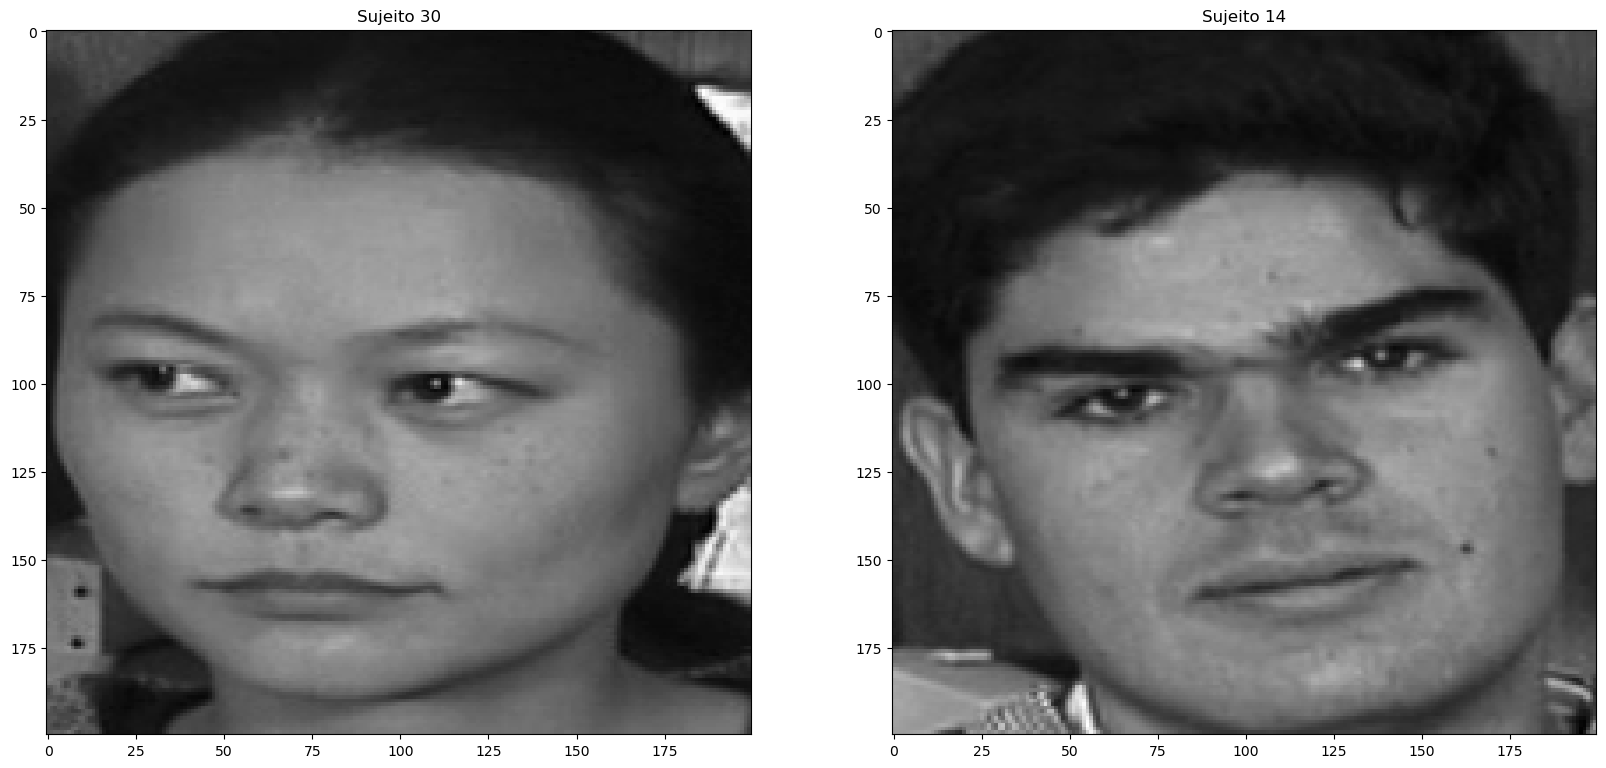

In [140]:
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.title("Sujeito " + str(sujeitos_teste[21]))
plt.imshow(dados_teste[21], cmap="gray")

plt.subplot(122)
plt.title("Sujeito " + str(sujeitos_teste[27]))
plt.imshow(dados_teste[27], cmap="gray")

plt.show()

In [143]:
predicao = modelo_lbph.predict(dados_teste[21])
print(predicao)

(30, 30.09267333610956)


In [144]:
predicao = modelo_lbph.predict(dados_teste[27])
print(predicao)

(14, 40.671644491011484)


Essas distâncias estão bem boas pra garantir que uma pessoa é ela mesmo

Então pode ser utilizada como prática mesmo para dizer que, por exemplo, esse sujeito é ele mesmo. Agora vamos ver um pouco sobre como esse algoritmo funciona. O “LBPH” é uma sigla de “Local Binary Pattern Histogram”. Como ele funciona?

Vamos pegar aqui uma imagem em escala de cinza. Ele passa uma janela deslizante no tamanho de 3x3 pixels, então pegue aqui esse exemplo dessa imagem e pense que essa imagem aqui é uma imagem em escala de cinza.

Então esses valores que estamos vendo aqui – “210”, “80” e “90” - é a escala de cinza, então lembrando que “0” é a imagem totalmente preta e 255 é totalmente branca. “210” está quase branco e “150” está naquele cinza, no meio do caminho.

Quando ele passa essa janela deslizante, ele vai pegar o pixel central, que nesse caso aqui é o “95” e vai fazer uma regra, então ele vai girar no sentido anti-horário e vai comparar cada pixel para saber se é maior ou menor que “95”. Se for maior ou igual a “95”, ele vai preencher esse pixel com “1”. Se for menor, ele vai preencher como “0”.

Então ele vai fazendo isso sucessivamente, e depois que ele fizer isso, vamos pegar a partir da extremidade, ou seja, do primeiro pixel, que seria o superior à esquerda. Vamos girar aqui no sentido horário para fazer uma palavra binária, então ficou “10011010”, que deu “143”.

Ele vai fazer isso com a imagem inteira. No final, o que vamos ter? Um histograma - de acordo com todos esses valores - e esse histograma, ele usa para comparar com uma imagem de inferência.

Então quando ele faz basicamente um filtro para você comparar que pixel central com os demais, automaticamente ele já está suavizando essa imagens, então quando suavizamos essa imagem, ele fica mais tolerante em relação a problemas de luminosidade.

Porque basicamente ele vai compensar esse efeito de luz na imagem inteira e vai diminuir esse efeito, então por isso ele consegue ser um pouco mais robusto que os demais.

E depois, para podermos comparar uma imagem de inferência com a imagem que foi treinada, também usamos a distância de similaridade, só que cada algoritmo tem uma distância própria. É de acordo com cada algoritmo.

Então no caso do “LBPH”, ele não é tão grande quanto os dos planos faciais de Eigenfaces e FisherFaces, então se você determinar uma distância para o “LBPH”, só pode usar com ele. A mesma coisa: se você determinar a distância para o Eigenfaces, só pode usar com ele e assim por diante.

Agora vamos partir pra analisar a precisão dos algoritmos

In [150]:
y_pred_eingenfaces = []

for item in dados_teste:
    y_pred_eingenfaces.append(modelo_eignenfaces.predict(item)[0])

In [152]:
acuracia_eingenfaces = accuracy_score(sujeitos_teste, y_pred_eingenfaces)

print(acuracia_eingenfaces)

0.724


In [153]:
y_pred_fisherfaces = []

for item in dados_teste:
    y_pred_fisherfaces.append(modelo_fisherfaces.predict(item)[0])

acuracia_fisherfaces = accuracy_score(sujeitos_teste, y_pred_fisherfaces)

print(acuracia_fisherfaces)

0.52


In [156]:
y_pred_lbph = []

for item in dados_teste:
    y_pred_lbph.append(modelo_lbph.predict(item)[0])

acuracia_lbph = accuracy_score(sujeitos_teste, y_pred_lbph)

print(acuracia_lbph)

0.792


os “benchmarks” indicam que para ter bons resultados com o Fisherfaces, por exemplo, as imagens precisam ser padronizadas como se fossem tiradas naquelas fotos de documento: as pessoas olhando para câmera e na mesma postura. Dessa forma ele consegue atender melhor.

Então, a recomendação é sempre de começar com o “LBPH” mas não deixe de fazer um estudo de “benchmarking” porque dependendo do seu conjunto de testes, pode ser que algum classificador nos surpreenda e tenha uma melhor performance do que o “LBPH”.